# Make dictionary

In [1]:
import pandas as pd
import torch
from transformers import (
    AutoTokenizer, 
    AutoModel, 
    AutoModelForSequenceClassification, 
    DataCollatorForTokenClassification, 
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer, 
    DataCollatorForLanguageModeling
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from transformers.models.bert.configuration_bert import BertConfig 
import numpy as np
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
#from training_args_module import training_args
import transformers
import os
import csv
from Bio import SeqIO
import argparse
import json
import pickle

import matplotlib.pyplot as plt
from collections import Counter

/home/ns5404/.conda/envs/dna/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
princeton_id = 'ns5404'
project_dir = f'/scratch/gpfs/{princeton_id}/QCB557_project'

# use gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model_out_dir = '/scratch/gpfs/ns5404/QCB557_project/models/replicate_043024/rep1/fine_tune_parallel_v1'

In [ ]:
config_seq = BertConfig.from_pretrained(f'/scratch/gpfs/{princeton_id}/QCB557_project/models/replicate_043024/rep1/fine_tune_parallel_v1/config.json', output_attentions=True)
print(config_seq.num_labels) #2 labels
model_seq = AutoModelForSequenceClassification.from_pretrained(model_out_dir, trust_remote_code=True, config=config_seq)
model_seq.to(device)

In [ ]:
config_base = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M", output_hidden_states=True, output_attentions=True)
print(config_base.num_labels) #2 labels
model_base = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config_base)
model_base.to(device)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, padding=True)
tokenizer.pad_token = "X"

In [ ]:
test = pd.read_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/test.csv')
train = pd.read_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/train.csv')
full = pd.concat([train, test], ignore_index=True)
full.to_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/all_seqs.csv')

In [ ]:
def get_model_output(model_base, model_seq, tokenizer, dataframe, device):
    results_dict = {}
    counter = 0

    for index, row in dataframe.iterrows():
        sequence = row['sequence']
        label = row['label']
        
        inputs = tokenizer(sequence, padding='max_length', max_length=128, return_tensors='pt').to(device)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs_seq = model_seq(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            hidden_states = outputs_seq.hidden_states
        
        with torch.no_grad():
            outputs_base = model_base(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
            attention_weights = outputs_base[1]

        key = f'seq_{index}_{label}'
        
        results_dict[key] = {
            "sequence": sequence,
            "input_ids": input_ids.cpu().detach().numpy().tolist(),
            "hidden_states": [tensor.cpu().detach().numpy() for tensor in hidden_states],
            "attention_weights": attention_weights.cpu().detach().numpy().tolist()
        }
        
        counter += 1
        percent = (counter/36799)*100
        
        if counter % 1000 == 0:
            print(f"{percent}% complete!")

    return results_dict

In [ ]:
results_dict = get_model_output(model_base, model_seq, tokenizer, full, device)

In [ ]:
def save_to_pickle(results_dict, file_path):
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(results_dict, pickle_file)

file_path = f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/results_dict.pkl'
save_to_pickle(results_dict, file_path)

In [ ]:
import pickle

def load_from_pickle(file_path):
    with open(file_path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

file_path = f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/results_dict.pkl'
results_dict = load_from_pickle(file_path)

# Printing the first and last key content
first_key = next(iter(results_dict))
last_key = list(results_dict.keys())[-1]

print("First key content:")
print(results_dict[first_key])

print("\nLast key content:")
print(results_dict[last_key])

# PCA Stuff

In [3]:
princeton_id = 'ns5404'

In [4]:
def load_from_pickle(file_path):
    with open(file_path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

file_path = f'/scratch/gpfs/{princeton_id}/QCB557_project/data/H3K4me3/results_dict.pkl'
results_dict = load_from_pickle(file_path)

In [5]:
#metadata table
#row: sequence
#columns: columns for each token position MAPPED to relevant motif OR other motif 
#column for label (postiive or negative)

positive_motifs = {
    443:'CCGG',
    136:'GGCC',
    685:'TCGC',
    46:'TATA',
    405:'GCGA',
    90:'GTCC'
}

negative_motifs = {
    92:'GGGG',
    102:'CCCC',
    247:'GCGG',
    270:'CGTC',
    2787:'CCGC',
    288:'TCGG',
    49:'CAAA'
}

seq_motifs = []
for seq,data in results_dict.items():
    this_input_ids = data['input_ids'][0]
    this_motifs = []
    this_motif_df = pd.DataFrame(0, index=np.arange(1), columns=list(positive_motifs.values()) + list(negative_motifs.values()))
    for input_id in this_input_ids:

        if input_id in positive_motifs.keys():
            this_motif_df[positive_motifs[input_id]]+=1
        elif input_id in negative_motifs.keys():
            this_motif_df[negative_motifs[input_id]]+=1
    
    seq_motifs.append(this_motif_df)

In [6]:
metadata = pd.concat(seq_motifs, axis=0, ignore_index=True)
metadata.index = list(results_dict.keys())
seq_labels = [x.split('_')[-1] for x in list(metadata.index)]
metadata['label'] = seq_labels

In [7]:
metadata

,CCGG,GGCC,TCGC,TATA,GCGA,GTCC,GGGG,CCCC,GCGG,CGTC,CCGC,TCGG,CAAA,label
seq_0_1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
seq_1_1,0,0,0,0,0,0,0,0,1,0,0,0,2,1
seq_2_0,0,1,0,2,0,0,0,0,0,0,0,1,1,0
seq_3_1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
seq_4_0,0,0,0,1,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_36794_0,0,0,0,2,0,0,1,0,0,0,0,0,0,0
seq_36795_0,0,1,1,0,0,0,0,0,0,0,0,1,1,0
seq_36796_1,0,0,0,2,0,0,0,0,0,0,0,0,0,1
seq_36797_0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
metadata.sum()



In [ ]:
metadata.to_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/metadata.csv')

In [ ]:
attention_weights_list = []
for seq,data in results_dict.items():
    attention_weights = data['attention_weights'][0]
    attention_weights_list.append(data['attention_weights'][0])

In [ ]:
attention_weights_df = pd.DataFrame(attention_weights_list)
attention_weights_df.index = list(results_dict.keys())
attention_weights_df.columns = [f'token{x}' for x in range(attention_weights_df.shape[1])]

In [ ]:
attention_weights_df

In [ ]:
attention_weights_df.to_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/attention_weights.csv')

In [ ]:
#perform PCA on attention weights matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(attention_weights_df)

# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(scaled_data)

PC_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
PC_df.index = attention_weights_df.index


In [ ]:
variance_ratio = pca.explained_variance_ratio_
variance_explained = variance_ratio.sum()

print("Variance explained by the first two principal components:", variance_ratio)
print("Total variance explained by the first two principal components:", variance_explained)

In [ ]:
#run UMAP on attention embeddings (no PCA??)
import umap

reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(attention_weights_df)
embedding = reducer.fit_transform(scaled_data)

In [ ]:
embedding_df = pd.DataFrame(embedding, index=attention_weights_df.index, columns=['UMAP1', 'UMAP2'])

In [ ]:
plt.scatter(
    PC_df['PC1'],
    PC_df['PC2']
)

In [ ]:
seqs_1 = metadata[metadata['label'] == '1']
seqs_0 = metadata[metadata['label'] == '0']

In [ ]:
seqs_1_index_list = seqs_1.index.tolist()
seqs_0_index_list = seqs_0.index.tolist()

Color by positive or negative label

In [ ]:
# Scatter plot PC1 and PC2
plt.scatter(PC_df['PC1'], PC_df['PC2'])

# Color sequences with label 1
plt.scatter(PC_df.loc[seqs_1_index_list]['PC1'], PC_df.loc[seqs_1_index_list]['PC2'], c='red', label='Label 1')

# Color sequences with labacel 0
plt.scatter(PC_df.loc[seqs_0_index_list]['PC1'], PC_df.loc[seqs_0_index_list]['PC2'], c='blue', label='Label 0')

# Add labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot colored by labels')
plt.legend()

# Show plot
plt.show()


In [ ]:
plt.scatter(
    embedding[:,0],
    embedding[:,1]
)

In [ ]:
# Scatter plot PC1 and PC2
plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'])

# Color sequences with label 1
plt.scatter(embedding_df.loc[seqs_1_index_list]['UMAP1'], embedding_df.loc[seqs_1_index_list]['UMAP2'], c='red', label='Label 1')

# Color sequences with label 0
plt.scatter(embedding_df.loc[seqs_0_index_list]['UMAP1'], embedding_df.loc[seqs_0_index_list]['UMAP2'], c='blue', label='Label 0')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP plot colored by label')
plt.legend()

# Show plot
plt.show()

In [ ]:
embedding_df

In [ ]:
sequences_with_TATA = metadata[metadata['TATA'] > 0].index.tolist()

In [ ]:
motif = 'GGCC'
sequences_with_motif = metadata[metadata[motif] > 0].index.tolist()

pastel_red = (1.0, 0.5, 0.5, 0.8)

plt.scatter(PC_df['PC1'], PC_df['PC2'], c='grey')

plt.scatter(PC_df.loc[sequences_with_motif]['PC1'], PC_df.loc[sequences_with_motif]['PC2'], c=pastel_red, label=f'{motif}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA plot colored by {motif} presence')
plt.legend()

# Show plot
plt.show()


In [ ]:
metadata

In [ ]:
motif = 'TCGG'
sequences_with_motif = metadata[metadata[motif] > 0].index.tolist()

pastel = (0.5, 0.7, 1.0, 0.5)

# Scatter plot PC1 and PC2
plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c='grey')

# Color sequences with label 1
plt.scatter(embedding_df.loc[sequences_with_motif]['UMAP1'], embedding_df.loc[sequences_with_motif]['UMAP2'], c=pastel, label=f'{motif}')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'UMAP plot colored by {motif} presence')
plt.legend()

# Show plot
plt.show()

In [ ]:
positive_sequences = []
negative_sequences = []

for sequence_id, sequence_row in metadata.iterrows():
    has_positive_motif = any(sequence_row[motif] > 0 for motif in positive_motifs.values())
    has_negative_motif = any(sequence_row[motif] > 0 for motif in negative_motifs.values())
    
    if has_positive_motif:
        positive_sequences.append(sequence_id)
    if has_negative_motif:
        negative_sequences.append(sequence_id)

In [ ]:
pastel_red = (1.0, 0.5, 0.5, 0.8)
pastel_blue = (0.5, 0.7, 1.0, 0.5)

plt.scatter(PC_df.loc[positive_sequences]['PC1'], PC_df.loc[positive_sequences]['PC2'], c=pastel_red, label='positive motifs')

plt.scatter(PC_df.loc[negative_sequences]['PC1'], PC_df.loc[negative_sequences]['PC2'], c=pastel_blue, label='negative motifs')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot colored by positive/negative motifs')
plt.legend()

# Show plot
plt.show()


In [ ]:
pastel_red = (1.0, 0.5, 0.5, 0.8)
pastel_blue = (0.5, 0.7, 1.0, 0.5)

plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c='grey')

# Color sequences with label 1
plt.scatter(embedding_df.loc[positive_sequences]['UMAP1'], embedding_df.loc[positive_sequences]['UMAP2'], c=pastel_red, label='positive motifs')

# Color sequences with label 0
plt.scatter(embedding_df.loc[negative_sequences]['UMAP1'], embedding_df.loc[negative_sequences]['UMAP2'], c=pastel_blue, label='negative motifs')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP plot colored by positive/negative motifs')
plt.legend()

# Show plot
plt.show()

# Hidden state PCA and UMAP

In [8]:
hidden_states_list = []
for seq,data in results_dict.items():
    hidden_states = data['hidden_states'][0]
    average_hidden_states = np.mean(hidden_states, axis=0)
    hidden_states_list.append(average_hidden_states)

In [9]:
hidden_states_df = pd.DataFrame(hidden_states_list)
hidden_states_df.index = list(results_dict.keys())
hidden_states_df.columns = [f'token{x}' for x in range(hidden_states_df.shape[1])]

In [10]:
hidden_states_df

,token0,token1,token2,token3,token4,token5,token6,token7,token8,token9,...,token758,token759,token760,token761,token762,token763,token764,token765,token766,token767
seq_0_1,-0.051783,0.071989,0.064005,-0.041827,-0.015294,-0.039235,-0.067864,-0.155217,0.034213,0.015284,...,0.046818,-0.039262,-0.015631,-0.011296,-0.026888,-0.012939,0.066621,0.031803,0.062406,0.094524
seq_1_1,-0.041045,0.075251,0.098468,-0.012026,-0.033557,-0.012826,-0.070192,-0.128662,-0.012522,-0.008907,...,0.049841,-0.045744,-0.006412,-0.010052,-0.007155,-0.025973,0.089073,0.038864,0.011213,0.093902
seq_2_0,-0.060103,0.071674,0.094719,-0.038586,-0.061953,-0.053443,-0.046001,-0.069048,0.030061,-0.052849,...,0.039821,-0.037280,-0.010477,-0.010961,-0.019075,-0.039806,0.087298,0.046666,0.054776,0.116695
seq_3_1,-0.059299,0.111453,0.076527,-0.040331,-0.033429,-0.057713,-0.092702,-0.118818,0.005580,-0.025156,...,0.060047,-0.032299,0.025327,-0.006112,-0.017073,-0.000853,0.096766,0.040025,0.033683,0.114965
seq_4_0,-0.033679,0.125151,0.059239,-0.089700,-0.079586,0.000306,-0.061195,-0.140607,0.017320,-0.005796,...,0.042823,-0.096967,-0.032421,-0.001776,-0.016042,-0.043354,0.113026,0.029959,0.082310,0.117560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
seq_36794_0,-0.061297,0.125473,0.081756,-0.064517,-0.071864,-0.041482,-0.096994,-0.167973,0.015361,-0.025029,...,0.023708,-0.048934,-0.020959,-0.033950,-0.004499,0.012161,0.067794,0.048482,0.020901,0.073684
seq_36795_0,-0.074933,0.147810,0.033771,-0.060066,-0.089790,-0.041471,-0.068829,-0.137252,-0.003872,0.020400,...,0.053900,-0.032786,-0.040182,-0.031159,0.005623,-0.028058,0.117287,0.016962,0.069830,0.125192
seq_36796_1,-0.064154,0.114634,0.080938,-0.057793,-0.073460,-0.046184,-0.067392,-0.131807,0.027637,-0.044524,...,0.067335,-0.056828,0.001863,-0.025105,-0.042983,-0.011561,0.098830,0.057675,0.063856,0.086540
seq_36797_0,-0.055479,0.040080,0.097382,-0.084467,-0.032376,-0.033674,-0.030669,-0.096062,0.008263,0.006875,...,0.067069,-0.026191,-0.023163,-0.000797,-0.024916,-0.029232,0.039487,0.037570,0.067922,0.067219


In [ ]:
hidden_states_df.to_csv(f'/scratch/gpfs/{princeton_id}/QCB557_project/data/hidden_states.csv')

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
#perform PCA on hidden states matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(hidden_states_df)

# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(scaled_data)

PC_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
PC_df.index = hidden_states_df.index

In [ ]:
variance_ratio = pca.explained_variance_ratio_
variance_explained = variance_ratio.sum()

print("Variance explained by the first two principal components:", variance_ratio)
print("Total variance explained by the first two principal components:", variance_explained)

In [13]:
import umap

reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(hidden_states_df)
embedding = reducer.fit_transform(scaled_data)

In [14]:
embedding_df = pd.DataFrame(embedding, index=hidden_states_df.index, columns=['UMAP1', 'UMAP2'])

In [ ]:
# Scatter plot PC1 and PC2
plt.scatter(PC_df['PC1'], PC_df['PC2'])

# Color sequences with label 1
plt.scatter(PC_df.loc[seqs_1_index_list]['PC1'], PC_df.loc[seqs_1_index_list]['PC2'], c='red', label='Label 1')

# Color sequences with labacel 0
plt.scatter(PC_df.loc[seqs_0_index_list]['PC1'], PC_df.loc[seqs_0_index_list]['PC2'], c='blue', label='Label 0')

# Add labels and legend
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot colored by labels')
plt.legend()

# Show plot
plt.show()

In [ ]:
# Scatter plot PC1 and PC2
plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'])

# Color sequences with label 1
plt.scatter(embedding_df.loc[seqs_1_index_list]['UMAP1'], embedding_df.loc[seqs_1_index_list]['UMAP2'], c='red', label='Label 1')

# Color sequences with label 0
plt.scatter(embedding_df.loc[seqs_0_index_list]['UMAP1'], embedding_df.loc[seqs_0_index_list]['UMAP2'], c='blue', label='Label 0')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP plot colored by label')
plt.legend()

# Show plot
plt.show()

In [15]:
motif = 'TATA'
sequences_with_motif = metadata[metadata[motif] > 0].index.tolist()

pastel_red = (1.0, 0.5, 0.5, 0.8)

plt.scatter(PC_df['PC1'], PC_df['PC2'], c='grey')

plt.scatter(PC_df.loc[sequences_with_motif]['PC1'], PC_df.loc[sequences_with_motif]['PC2'], c=pastel_red, label=f'{motif}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'PCA plot colored by {motif} presence')
plt.legend()

# Show plot
plt.show()


NameError: name 'PC_df' is not defined

/tmp/ipykernel_625902/1343077798.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embedding_df.loc[sequences_with_motif]['UMAP1'], embedding_df.loc[sequences_with_motif]['UMAP2'], c=pastel, label=f'{motif}')


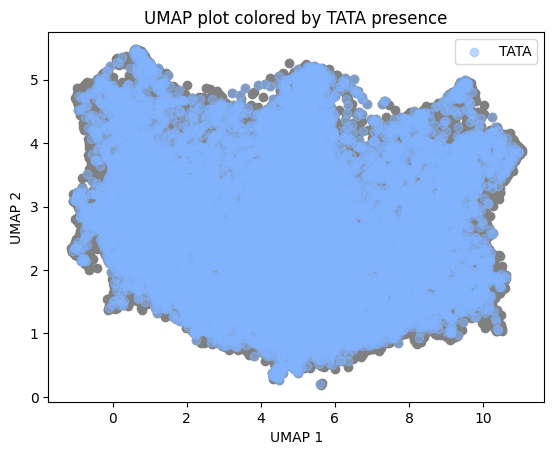

In [16]:
motif = 'TATA'
sequences_with_motif = metadata[metadata[motif] > 0].index.tolist()

pastel = (0.5, 0.7, 1.0, 0.5)

# Scatter plot PC1 and PC2
plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c='grey')

# Color sequences with label 1
plt.scatter(embedding_df.loc[sequences_with_motif]['UMAP1'], embedding_df.loc[sequences_with_motif]['UMAP2'], c=pastel, label=f'{motif}')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title(f'UMAP plot colored by {motif} presence')
plt.legend()

# Show plot
plt.show()

In [ ]:
pastel_red = (1.0, 0.5, 0.5, 0.8)
pastel_blue = (0.5, 0.7, 1.0, 0.5)

plt.scatter(PC_df.loc[positive_sequences]['PC1'], PC_df.loc[positive_sequences]['PC2'], c=pastel_red, label='positive motifs')

plt.scatter(PC_df.loc[negative_sequences]['PC1'], PC_df.loc[negative_sequences]['PC2'], c=pastel_blue, label='negative motifs')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA plot colored by positive/negative motifs')
plt.legend()

# Show plot
plt.show()


In [ ]:
pastel_red = (1.0, 0.5, 0.5, 0.8)
pastel_blue = (0.5, 0.7, 1.0, 0.5)

plt.scatter(embedding_df['UMAP1'], embedding_df['UMAP2'], c='grey')

# Color sequences with label 1
plt.scatter(embedding_df.loc[positive_sequences]['UMAP1'], embedding_df.loc[positive_sequences]['UMAP2'], c=pastel_red, label='positive motifs')

# Color sequences with label 0
plt.scatter(embedding_df.loc[negative_sequences]['UMAP1'], embedding_df.loc[negative_sequences]['UMAP2'], c=pastel_blue, label='negative motifs')

# Add labels and legend
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('UMAP plot colored by positive/negative motifs')
plt.legend()

# Show plot
plt.show()